In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis/test.txt
/kaggle/input/sentiment-analysis/train.txt


In [2]:
!pip install -q spacy tensorflow transformers pandas matplotlib

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [4]:
train_data = pd.read_csv("/kaggle/input/sentiment-analysis/train.txt", header=None, delimiter=";")
test_data = pd.read_csv("/kaggle/input/sentiment-analysis/test.txt", header=None, delimiter=";")

In [5]:
train_data.rename(columns={0: "text", 1: "sentiment_class"}, inplace=True)
test_data.rename(columns={0: "text", 1: "sentiment_class"}, inplace=True)

In [6]:
!python -m spacy download en_core_web_md -q

/usr/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 37.9 MB/s eta 0:00:00:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [7]:
en_dict = spacy.load("en_core_web_md")

def preprocess_text(text, wrapper=en_dict):
    doc = wrapper(text)
    
    return " ".join( [token.lemma_.lower().strip() for token in doc if not token.is_stop] )

In [8]:
for d, name in ((train_data, "train"), (test_data, "test")):
    print(name)
    d["preprocessed_text"] = d.text.apply(lambda text: preprocess_text(text))

train
test


In [9]:
train_data.head()

,text,sentiment_class,preprocessed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [10]:
tokenizer = Tokenizer()

In [11]:
tokenizer.fit_on_texts(train_data.preprocessed_text.values)

In [12]:
list(tokenizer.word_index.items())[:10]

[('feel', 1),
 ('like', 2),
 ('m', 3),
 ('not', 4),
 ('feeling', 5),
 ('know', 6),
 ('time', 7),
 ('t', 8),
 ('want', 9),
 ('think', 10)]

In [13]:
word_index = tokenizer.word_index

In [14]:
len(word_index) # number of words/tokens

11896

In [15]:
train_sequences = tokenizer.texts_to_sequences(train_data.preprocessed_text.values)

max_sequence_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_len, truncating="post")

In [16]:
test_sequences = tokenizer.texts_to_sequences(test_data.preprocessed_text.values)
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_len)

In [17]:
train_sequences[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,  146,  114, 1882,   37,
          1,  646, 1736,   87, 1302, 1019,  811,   92,   68,  395,   17,
        528], dtype=int32)

In [18]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_data.sentiment_class)
y_test  = encoder.transform(test_data.sentiment_class)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## 2nd model - lstm

In [19]:
vocab_size = len(word_index) + 1

In [20]:
vocab_size

11897

In [21]:
embedding_dim = max_sequence_len

In [22]:
N_CLASSES = len( y_train[0] )
N_CLASSES

6

In [23]:
lstm_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_sequence_len),
    # Bidirectional(LSTM(64)),  
    LSTM(64),
    Dropout(0.4), 
    Dense(32, activation="leaky_relu", kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)), 
    Dropout(0.4), 
    Dense(N_CLASSES, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
lstm_model.compile(
    loss="categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy", Precision(), Recall(), AUC()]
)

In [25]:
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
train_sequences

array([[   0,    0,    0, ...,  395,   17,  528],
       [   0,    0,    0, ...,    5, 1145, 1516],
       [   0,    0,    0, ...,  188,   76,   37],
       ...,
       [   0,    0,    0, ...,  153,   24, 1045],
       [   0,    0,    0, ...,    3,  188,    8],
       [   0,    0,    0, ...,    1,  143, 2072]], dtype=int32)

In [27]:
y_train

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]])

In [28]:
epochs = 50
validation_split = 0.2
patience = 10

In [29]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience) 

In [30]:
%%time
history = lstm_model.fit(
    train_sequences, 
    y_train, 
    epochs=epochs, 
    verbose=1, 
    validation_split=validation_split,
    callbacks=[early_stopping]
)

Epoch 1/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.3184 - auc: 0.6967 - loss: 3.1160 - precision: 0.3804 - recall: 0.0027 - val_accuracy: 0.3306 - val_auc: 0.7873 - val_loss: 1.5479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4739 - auc: 0.8330 - loss: 1.3587 - precision: 0.7723 - recall: 0.2380 - val_accuracy: 0.6981 - val_auc: 0.9374 - val_loss: 0.9402 - val_precision: 0.9183 - val_recall: 0.5688
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7139 - auc: 0.9447 - loss: 0.9013 - precision: 0.9496 - recall: 0.5690 - val_accuracy: 0.7794 - val_auc: 0.9569 - val_loss: 0.8146 - val_precision: 0.9178 - val_recall: 0.6106
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8210 - auc: 0.9736 - loss: 0.6913 - precision: 0.9401 - recall: 0.6853 - val_accuracy: 0.8381 - val_auc: 0.9677 - val_loss: 0.7007 - val_precision: 0.9066 - val_recall: 0.7369
Epoch 5/50
400/400 ━━━

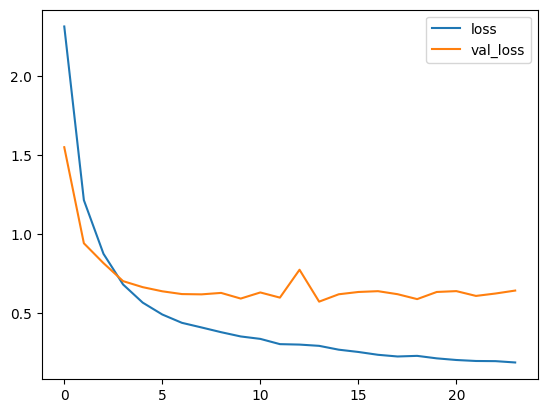

In [31]:
loss, val_loss = history.history["loss"], history.history["val_loss"]

plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

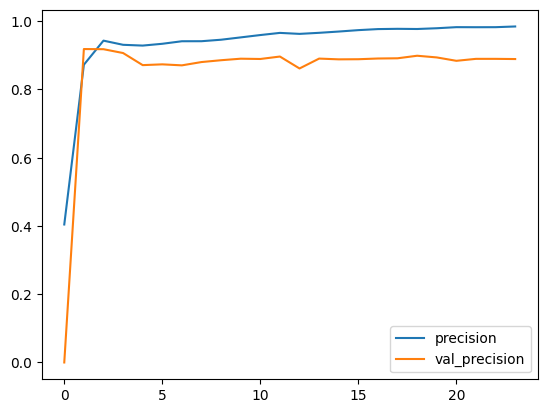

In [33]:
loss, val_loss = history.history["precision"], history.history["val_precision"]

plt.plot(loss, label="precision")
plt.plot(val_loss, label="val_precision")
plt.legend()
plt.show()

In [34]:
preds = lstm_model.predict(test_sequences)
labels = preds.argmax(axis=1)

print(classification_report(y_test.argmax(axis=1), labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       275
           1       0.88      0.87      0.87       224
           2       0.91      0.91      0.91       695
           3       0.70      0.72      0.71       159
           4       0.91      0.93      0.92       581
           5       0.73      0.65      0.69        66

    accuracy                           0.88      2000
   macro avg       0.84      0.83      0.83      2000
weighted avg       0.88      0.88      0.88      2000



In [35]:
print(accuracy_score(y_test.argmax(axis=1), labels))

0.883


In [36]:
lstm_model.save("/kaggle/working/lstm_model.keras")

In [37]:
loaded_model = load_model("/kaggle/working/lstm_model.keras")

In [38]:
sample = "I hope that the new matrix movie can be so great as the last ones"

In [39]:
preprocess_sample = tokenizer.texts_to_sequences( [preprocess_text(sample)] )
preprocess_sample = np.array( preprocess_sample )

preprocess_sample = pad_sequences(preprocess_sample, maxlen=max_sequence_len)

In [40]:
pred = loaded_model.predict(preprocess_sample).argmax(axis=1)

class_name = encoder.inverse_transform( pred )
class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


array(['sadness'], dtype=object)

In [41]:
train_data.sentiment_class.unique()

array(['fear', 'joy', 'anger', 'sadness', 'love', 'surprise'],
      dtype=object)

In [42]:
samples = [
    "i love dogs and cats",
    "i hated the movie",
    "i loved the movie",
    "superman is the most boring superhero"
]

samples = [preprocess_text(t) for t in samples]
samples = tokenizer.texts_to_sequences(samples)


samples = pad_sequences(samples, maxlen=max_sequence_len)

In [43]:
pred = loaded_model.predict(samples).argmax(axis=1)

class_name = encoder.inverse_transform( pred )
class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


array(['joy', 'sadness', 'sadness', 'sadness'], dtype=object)

## 3rd model

In [59]:
def encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)

    input_ids = []
    attention_masks = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:chunk_size+i].tolist()

        encs = tokenizer.encode_batch(text_chunk)
        input_ids.extend( [enc.ids for enc in encs] )
        attention_masks.extend( [enc.attention_mask for enc in encs] )

    return np.array(input_ids), np.array(attention_masks)

In [47]:
bert_tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

In [50]:
os.getcwd()

'/kaggle/working'

In [51]:
bert_tokenizer.save_pretrained( os.getcwd() )

('/kaggle/working/tokenizer_config.json',
 '/kaggle/working/special_tokens_map.json',
 '/kaggle/working/vocab.txt',
 '/kaggle/working/added_tokens.json')

In [52]:
fast_tokenizer = BertWordPieceTokenizer("/kaggle/working/vocab.txt", lowercase=False)

In [53]:
fast_tokenizer

Tokenizer(vocabulary_size=119547, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    train_data.preprocessed_text, 
    train_data.sentiment_class, 
    test_size=0.2, 
    random_state=2024, 
    stratify=train_data.sentiment_class
)

In [55]:
maxlen = 100

In [60]:
X_train, train_mask = encode(X_train, train_ds = (
    tf.data.Dataset.from_tensor_slices( ( (X_train, train_mask), y_train ) )
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
), maxlen=maxlen)
X_val, val_mask = encode(X_val, fast_tokenizer, maxlen=maxlen)
X_test, test_mask = encode(test_data.preprocessed_text, fast_tokenizer, maxlen=maxlen)

100%|██████████| 8/8 [00:00<00:00, 159.69it/s]


In [61]:
X_train.shape

(12800, 100)

In [62]:
X_train[0]

array([  101, 38008, 12718, 47116, 10454, 10554, 23239, 14526, 14446,
       31907,   102,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0])

In [64]:
train_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [65]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_val   = encoder.transform(y_val)
y_test  = encoder.transform(test_data.sentiment_class)

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [66]:
BATCH_SIZE = 16

In [67]:
train_ds = (
    tf.data.Dataset.from_tensor_slices( ( (X_train, train_mask), y_train ) )
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
)

In [68]:
val_ds = (
    tf.data.Dataset.from_tensor_slices( ( (X_val, val_mask), y_val ) )
    .batch(BATCH_SIZE)
    .cache()
)

In [69]:
test_ds = (
    tf.data.Dataset.from_tensor_slices( ( (X_test, test_mask), y_test ) )
    .batch(BATCH_SIZE)
)

In [85]:
@tf.keras.utils.register_keras_serializable(package="Custom", name="TransformerLayer")
class TransformerLayer(tf.keras.Layer):    
    def __init__(self, transformer, **kwargs):        
        super().__init__(**kwargs)  

        self.transformer = transformer  

    def call(self, inputs):
        
        input_ids, attention_mask = inputs 
        
        outputs = self.transformer(input_ids=input_ids, attention_mask=attention_mask) 
        return outputs.last_hidden_state  

    def get_config(self):
        config = super().get_config() 
        config.update({
            "transformer_config": self.transformer.config.to_dict()
        })
        return config 

    @classmethod
    def from_config(cls, config):
        
        transformer_config = transformers.DistilBertConfig.from_dict(config["transformer_config"])
        transformer = transformers.TFDistilBertModel.from_pretrained(
            "distilbert-base-multilingual-cased",
            config=transformer_config
        )
        return cls(transformer=transformer)

In [89]:
def model(transformer, maxlen=512, n_classes=6):

    input_words_ids = tf.keras.layers.Input(
        shape=(maxlen, ), dtype=tf.int32, name="input_word_ids", 
    )
    attention_mask = tf.keras.layers.Input(
        shape=(maxlen, ), dtype=tf.int32, name="attention_mask", 
    )

    sequence_output = TransformerLayer(transformer)(
        [input_words_ids, attention_mask]
    )

    cls_token = sequence_output[:, 0, :]

    out = Dense(n_classes, activation="softmax")(cls_token)

    model = tf.keras.Model(
        inputs = [input_words_ids, attention_mask], outputs=out
    )

    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(), Recall(), AUC()],
    )

    return model

In [90]:
transformer_layer = transformers.TFDistilBertModel.from_pretrained(
    "distilbert-base-multilingual-cased"
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [113]:
transformer_based_model = model(transformer_layer, maxlen=maxlen)

In [114]:
transformer_based_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_4       │ (None, 100, 768)       │              0 │ input_word_ids[0][0],  │
│ (TransformerLayer)        │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ transformer_layer_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 6)              │          4,614 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
transformer_based_model.layers[0].trainable = False
transformer_based_model.layers[1].trainable = False
transformer_based_model.layers[2].trainable = False

In [116]:
transformer_based_model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_word_ids            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_layer_4       │ (None, 100, 768)       │              0 │ input_word_ids[0][0],  │
│ (TransformerLayer)        │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 768)            │              0 │ transformer_layer_4[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 6)              │          4,614 │ get_item_2[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

In [117]:
n_steps = X_train.shape[0] // BATCH_SIZE
epochs = 20

n_steps

800

In [118]:
%%time
history = transformer_based_model.fit(
    train_ds, 
    steps_per_epoch=n_steps, 
    validation_data=val_ds, 
    epochs=epochs
)

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.2003 - auc_2: 0.5821 - loss: 1.7715 - precision_2: 0.4831 - recall_2: 9.7708e-05 - val_accuracy: 0.3141 - val_auc_2: 0.6961 - val_loss: 1.6172 - val_precision_2: 1.0000 - val_recall_2: 6.2500e-04
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.3271 - auc_2: 0.7052 - loss: 1.6008 - precision_2: 0.1090 - recall_2: 8.4500e-05 - val_accuracy: 0.3244 - val_auc_2: 0.7089 - val_loss: 1.5918 - val_precision_2: 0.6667 - val_recall_2: 6.2500e-04
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 52s 65ms/step - accuracy: 0.3411 - auc_2: 0.7131 - loss: 1.5869 - precision_2: 0.6498 - recall_2: 9.9314e-04 - val_accuracy: 0.3356 - val_auc_2: 0.7154 - val_loss: 1.5806 - val_precision_2: 1.0000 - val_recall_2: 3.1250e-04
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 51s 64ms/step - accuracy: 0.3517 - auc_2: 0.7291 - loss: 1.5547 - precision_2: 0.6966 - recall_2: 9.6678e-04 - val_accuracy: 0.3481 - val_auc_2: 0.7209 - val_loss: 1.57

In [119]:
transformer_based_model.save("/kaggle/working/transformer_based_model.keras")

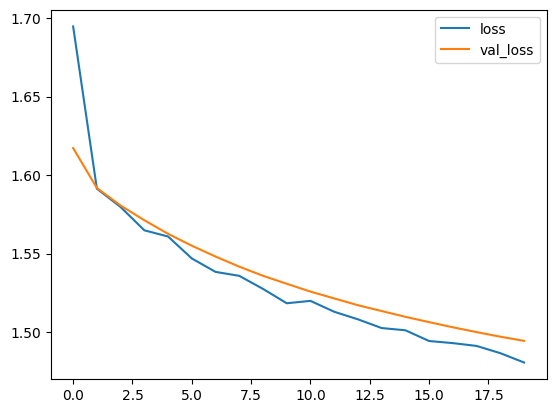

In [120]:
loss, val_loss = history.history["loss"], history.history["val_loss"]

plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

In [121]:
from transformers import TFDistilBertModel
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope


loaded_model = load_model(
    "/kaggle/working/transformer_based_model.keras",
    custom_objects = {"TransformerLayer": TransformerLayer}
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [122]:
preds = loaded_model.predict([X_test, test_mask])
labels = preds.argmax(axis=1)

print(classification_report(y_test.argmax(axis=1), labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 174ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.00      0.00      0.00       224
           2       0.45      0.76      0.56       695
           3       0.00      0.00      0.00       159
           4       0.38      0.54      0.45       581
           5       0.00      0.00      0.00        66

    accuracy                           0.42      2000
   macro avg       0.14      0.22      0.17      2000
weighted avg       0.27      0.42      0.33      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [123]:
print(accuracy_score(y_test.argmax(axis=1), labels))

0.4205


In [124]:
samples = [
    "i love dogs and cats",
    "i hated the movie",
    "i loved the movie",
    "superman is the most boring superhero"
]
samples = [preprocess_text(t) for t in samples]

samples = np.array(samples)
samples, samples_mask = encode(samples, fast_tokenizer, maxlen=maxlen)

100%|██████████| 1/1 [00:00<00:00, 501.95it/s]


In [125]:
preds = loaded_model.predict([samples, samples_mask]).argmax(axis=1)

class_name = encoder.inverse_transform( preds )
class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array(['joy', 'joy', 'joy', 'joy'], dtype=object)